In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import shutil

In [2]:
OUT_DIR = './imgs'
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)

os.mkdir(OUT_DIR)

In [3]:
response = requests.get('https://docs.google.com/spreadsheet/ccc?key=1pG-KbEGtl7QHyF0bolPf2sWN__m63soeGuircwflwV0&output=csv')
with open('results.csv', 'wb') as f:
    f.write(response.content)

In [4]:
serial_time = {
    '15M' : {'Total time':30.73, 'Algo time':23.55},
    '10M' : {'Total time':16.93, 'Algo time':12.84},
    '5M' : {'Total time':9.92, 'Algo time':7.51},
    '1M' : {'Total time':1.34, 'Algo time':0.99},
    # '100K': {'Total time':0.09, 'Algo time':0.08}
}

In [5]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8,5)})

In [6]:
df = pd.read_csv("results.csv")

In [7]:
df.columns

Index(['Informazioni cronologiche', 'Run Status', 'Job Codename',
       'Minimum Distance', 'Cluster job ID', 'Input size',
       'Reading time (seconds)', 'Scattering time (seconds)', 'Submitted on',
       'Github commit SHA', 'Github commit author', 'Output from process 0',
       'Number of CPUs', 'Number of Nodes', 'GB of memory',
       'Maximum duration (minutes)', 'Total run time (seconds)',
       'Placing strategy', 'Bechmark name'],
      dtype='object')

In [8]:
input_sizes = list(serial_time.keys())

df.drop(df[~df['Run Status'].str.contains('successfully')].index, inplace=True)
df['N processes'] = df['Number of CPUs'] * df['Number of Nodes']

df["Speedup"] = df.apply(lambda x: serial_time[x['Input size']]['Total time']/x['Total run time (seconds)'] if x['Input size'] in input_sizes else np.nan, axis=1)
df = df[df['Speedup'].notna()]

df["Efficiency"] = df["Speedup"]/df["N processes"]

df = df.astype({'N processes':'str'})

In [9]:
df.head()


,Informazioni cronologiche,Run Status,Job Codename,Minimum Distance,Cluster job ID,Input size,Reading time (seconds),Scattering time (seconds),Submitted on,Github commit SHA,...,Number of CPUs,Number of Nodes,GB of memory,Maximum duration (minutes),Total run time (seconds),Placing strategy,Bechmark name,N processes,Speedup,Efficiency
100,10/01/2023 16.48.32,Finished successfully 🧸,NaN,2.236068,9124726.hpc-head-n1.unitn.it,1M,0.297424,0.002527,Tue Jan 10 16:48:09 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,...,1,1,1,5,1.581849,pack,fitting-lizard,1,0.847110,0.847110
101,10/01/2023 16.48.54,Finished successfully 🧸,NaN,2.236068,9124730.hpc-head-n1.unitn.it,1M,0.246446,0.003908,Tue Jan 10 16:48:31 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,...,1,1,1,5,1.575881,scatter,fitting-lizard,1,0.850318,0.850318
102,10/01/2023 16.49.18,Finished successfully 🧸,NaN,2.236068,9124732.hpc-head-n1.unitn.it,1M,0.504888,0.004050,Tue Jan 10 16:48:54 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,...,1,1,1,5,1.921141,pack:excl,fitting-lizard,1,0.697502,0.697502
103,10/01/2023 16.49.31,Finished successfully 🧸,NaN,2.236068,9124734.hpc-head-n1.unitn.it,1M,0.575961,0.005321,Tue Jan 10 16:49:18 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,...,1,1,1,5,1.980209,scatter:excl,fitting-lizard,1,0.676696,0.676696
104,10/01/2023 16.49.44,Finished successfully 🧸,NaN,2.236068,9124736.hpc-head-n1.unitn.it,1M,0.196738,0.004628,Tue Jan 10 16:49:31 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,...,1,2,1,5,0.943738,pack,fitting-lizard,2,1.419886,0.709943


In [10]:
def plot_time_by_n_processes_and_placing_strategy(df):
  strategies = ['pack', 'scatter', 'pack:excl', 'scatter:excl']

  ticks = list(df['N processes'].unique())
  plt.xticks(range(0,len(ticks)), ticks)
  
  for strat in strategies:
    data = df[df['Placing strategy'] == strat]
  
    sns.lineplot(data=data, x='N processes', y='Total run time (seconds)', hue='Input size', palette='tab10', errorbar=None, marker="o").set(title=f'{strat} strategy')
    plt.savefig(f'{OUT_DIR}/Total_time_{strat}.svg')
    plt.show()

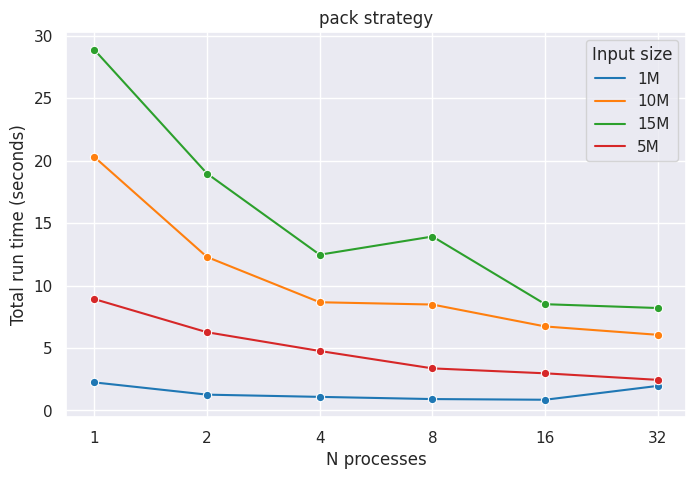

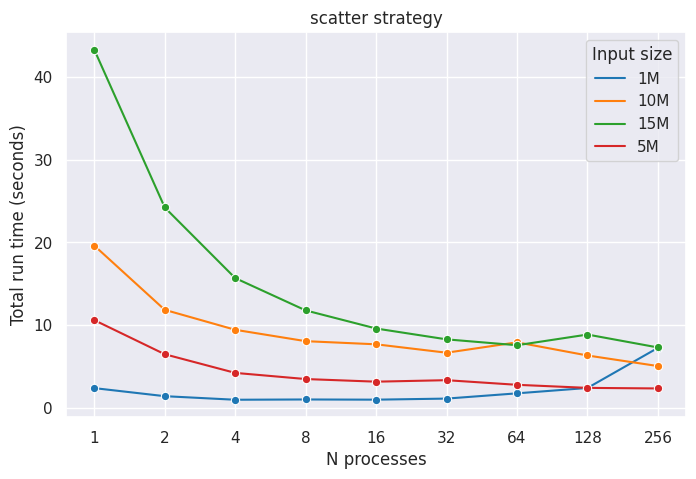

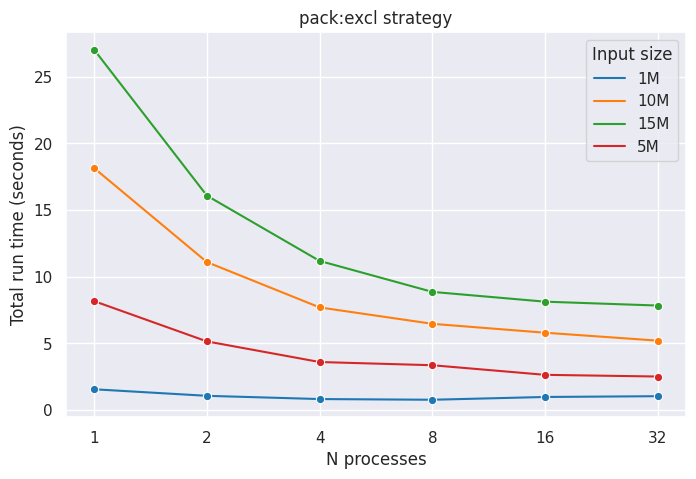

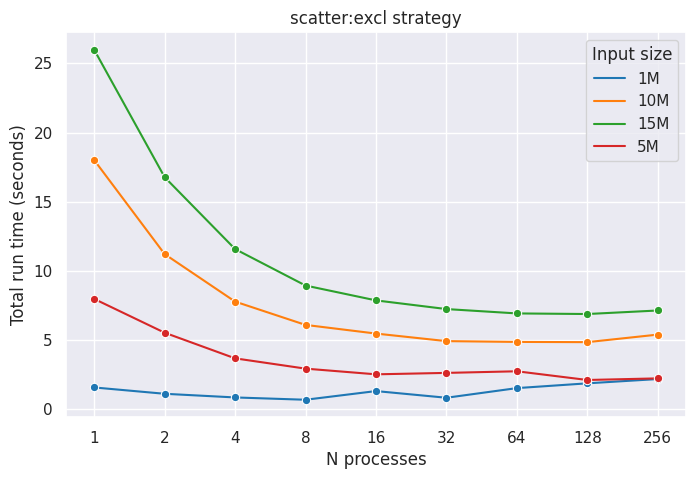

In [11]:
plot_time_by_n_processes_and_placing_strategy(df)

In [12]:
def plot_speedup_by_n_processes_and_placing_strategy(df):
  strategies = ['pack', 'scatter', 'pack:excl', 'scatter:excl']

  ticks = list(df['N processes'].unique())
  plt.xticks(range(0,len(ticks)), ticks)
  
  for strat in strategies:
    data = df[df['Placing strategy'] == strat]

    sns.lineplot(data=data, x='N processes', y='Speedup', hue='Input size', palette='tab10', errorbar=None, marker="o").set(title=f'{strat} strategy')
    plt.savefig(f'{OUT_DIR}/Speedup_{strat}.svg')
    plt.show()

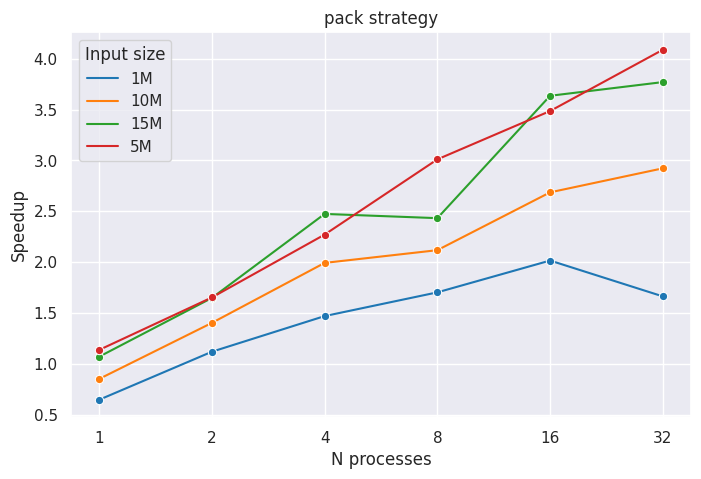

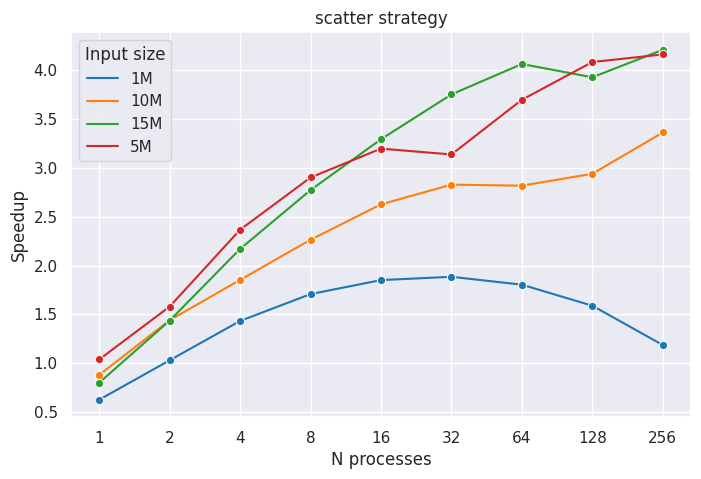

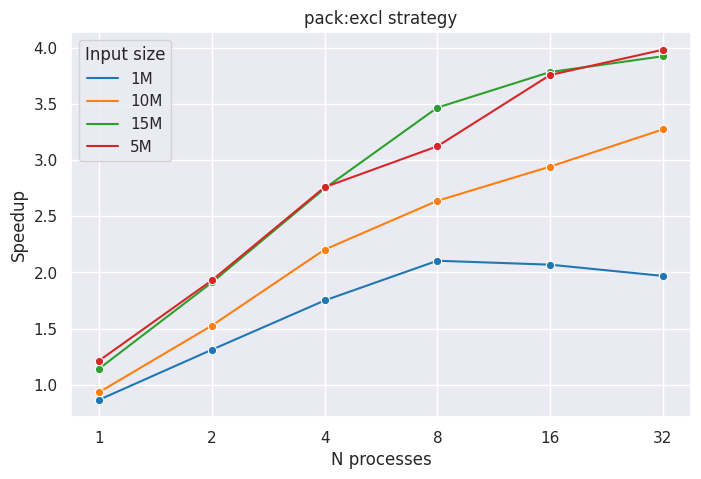

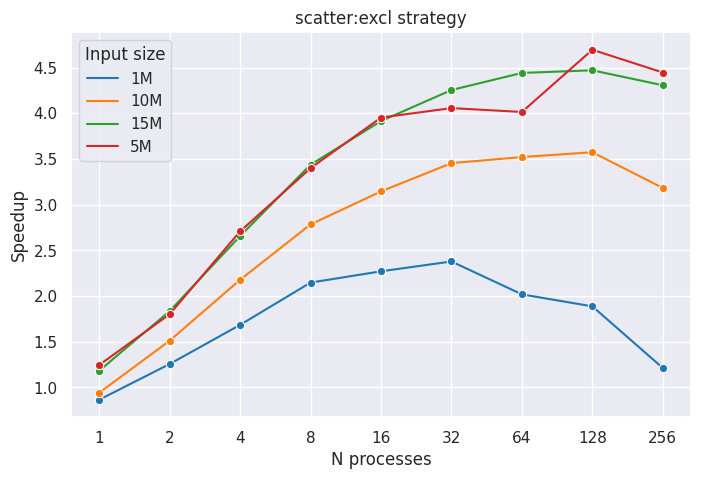

In [13]:
plot_speedup_by_n_processes_and_placing_strategy(df)

In [14]:
def plot_efficiency_by_n_processes_and_placing_strategy(df):
  strategies = ['pack', 'scatter', 'pack:excl', 'scatter:excl']

  ticks = list(df['N processes'].unique())
  plt.xticks(range(0,len(ticks)), ticks)
  
  for strat in strategies:
    data = df[df['Placing strategy'] == strat]

    sns.lineplot(data=data, x='N processes', y='Efficiency', hue='Input size', palette='tab10', errorbar=None, marker="o").set(title=f'{strat} strategy')
    plt.savefig(f'{OUT_DIR}/Efficiency_{strat}.svg')
    plt.show()

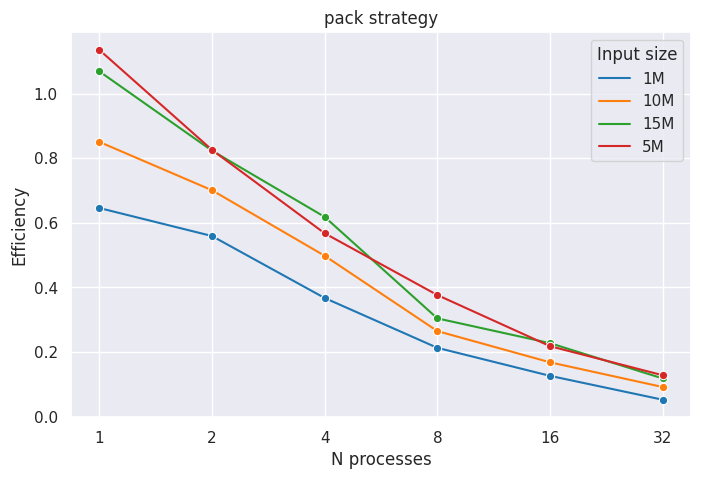

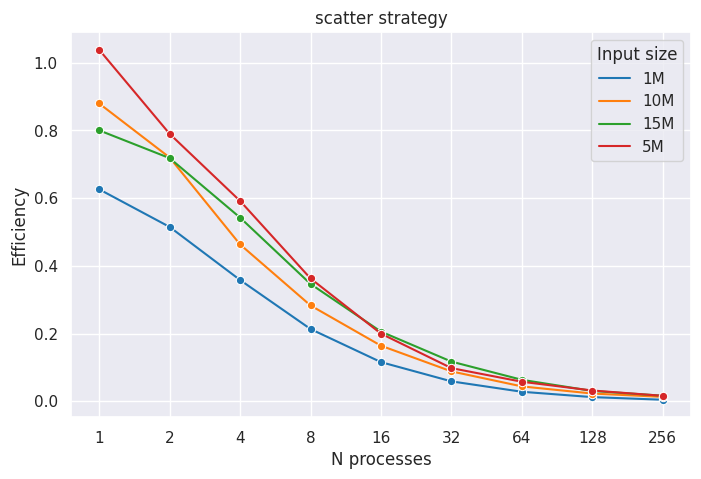

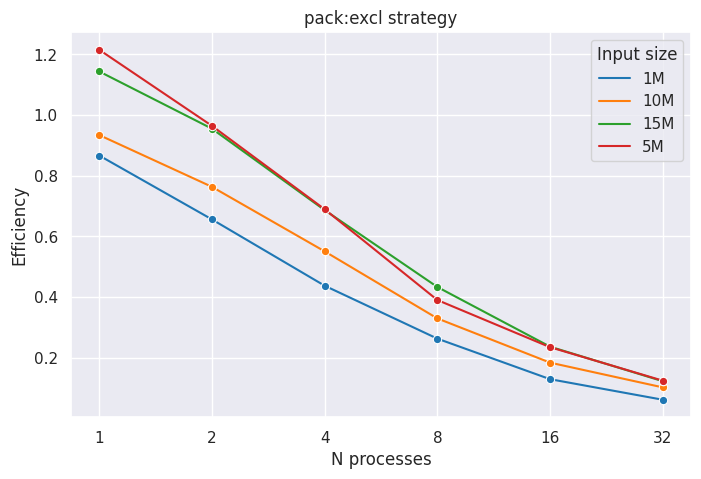

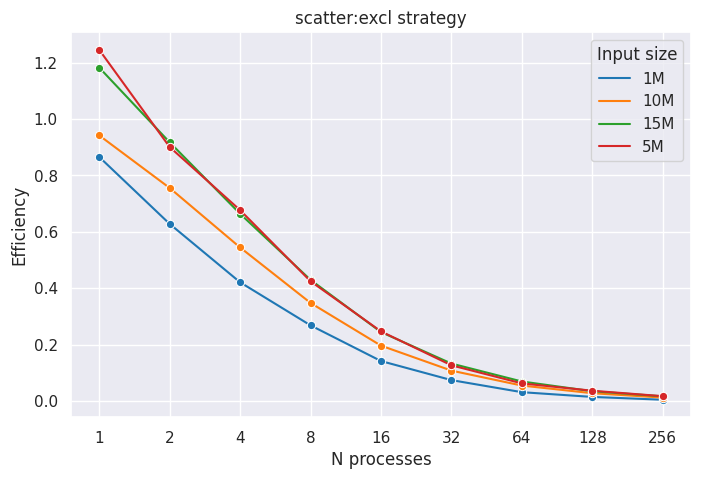

In [15]:
plot_efficiency_by_n_processes_and_placing_strategy(df)